In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import librosa
import mpl_scatter_density
import umap
from tqdm.notebook import tqdm
import h5py
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import json
import pandas as pd
import os

/home/bmcfee/miniconda/envs/ismir2022embedding/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
import json
import pandas as pd
import os

---
# Embedding plots

In [93]:
#FEATURES = 'vggish'
FEATURES = 'openl3'

In [94]:
data = h5py.File('embeddings.h5', 'r')

In [95]:
train_idx = set(pd.read_csv('openmic2018_train.csv', header=None)[0].values)

In [96]:
openmic_idx = pd.Series(data[f'openmic/{FEATURES}/keys'])

In [97]:
openmic_istrain = openmic_idx.map(lambda x: x in train_idx)

In [98]:
X_om = data[f'openmic/{FEATURES}/features']
X_om = np.take(X_om, np.where(openmic_istrain.values)[0], axis=0)
Y_om = np.zeros(len(X_om))

X_ir = data[f'irmas/{FEATURES}/features']
Y_ir = np.ones(len(X_ir))

In [99]:
# Do this viz on 50% of the openmic data to start
X = np.concatenate([X_om[::5], X_ir])
Y = np.concatenate([Y_om[::5], Y_ir])

In [100]:
X.shape, Y.shape

((451010, 512), (451010,))

In [101]:
Y.mean()

0.37166581672246735

In [102]:
U = umap.UMAP(verbose=True, random_state=2022)

In [103]:
# Fit the UMAP embedding on a random sample of 50K vectors
U.fit(X[np.random.choice(len(X), size=50000)])
#U.fit(X)

UMAP(random_state=2022, verbose=True)
Wed Apr 13 13:39:16 2022 Construct fuzzy simplicial set
Wed Apr 13 13:39:16 2022 Finding Nearest Neighbors
Wed Apr 13 13:39:17 2022 Building RP forest with 16 trees
Wed Apr 13 13:39:18 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Wed Apr 13 13:39:21 2022 Finished Nearest Neighbor Search
Wed Apr 13 13:39:22 2022 Construct embedding


Epochs completed: 100%| ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 200/200 [00:34]


Wed Apr 13 13:40:02 2022 Finished embedding


UMAP(random_state=2022, verbose=True)

In [104]:
embedding = U.transform(X)

Wed Apr 13 13:40:12 2022 Worst tree score: 0.54896000
Wed Apr 13 13:40:12 2022 Mean tree score: 0.55753125
Wed Apr 13 13:40:12 2022 Best tree score: 0.56420000
Wed Apr 13 13:40:12 2022 Forward diversification reduced edges from 750000 to 309560
Wed Apr 13 13:40:12 2022 Reverse diversification reduced edges from 309560 to 309560
Wed Apr 13 13:40:12 2022 Degree pruning reduced edges from 361702 to 360459
Wed Apr 13 13:40:12 2022 Resorting data and graph based on tree order
Wed Apr 13 13:40:13 2022 Building and compiling search function


Epochs completed: 100%| ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 30/30 [00:22]


In [105]:
colors = ['#0271AE', '#DC2830']
data = ['OpenMIC', 'IRMAS']

/home/bmcfee/miniconda/envs/ismir2022embedding/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/bmcfee/miniconda/envs/ismir2022embedding/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


[Text(0.5, 1.0, 'openl3 - raw')]

<Figure size 576x576 with 1 Axes>

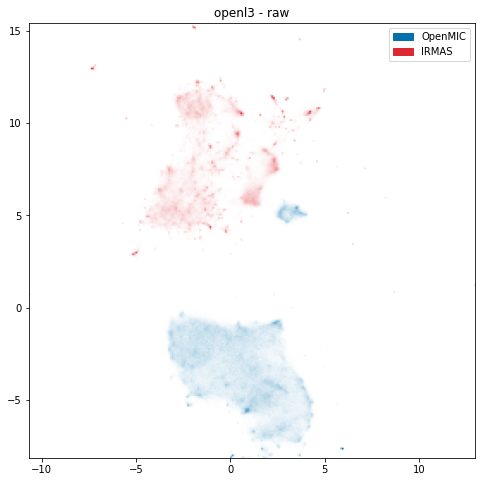

In [106]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

handles = []

for c in [0, 1]:
    ax.scatter_density(embedding[Y == c][:, 0], embedding[Y==c][:, 1], color=colors[c], dpi=50)
    handles.append(mpatches.Patch(color=colors[c], label=data[c]))
    
ax.legend(handles=handles)
ax.set(title=f'{FEATURES} - raw')

---
# LDA

In [107]:
#scaler = StandardScaler()
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X, Y)
#pipe = Pipeline([('scaler', scaler), ('LDA', LDA)])
#idx = np.random.randint(0, len(X), size=50000)
#pipe.fit(X[idx], Y[idx])
#pipe.fit(X, Y)

LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')

In [108]:
v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

In [109]:
Xdeb = X.dot(np.eye(len(A)) - A)

In [110]:
#Xsproj = Xs.dot(v.T)
Xsproj = LDA.transform(X)

<matplotlib.legend.Legend object at 0x7f24df8dc310>

<Figure size 432x288 with 1 Axes>

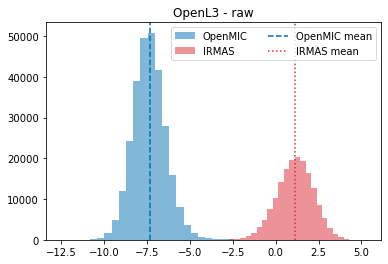

In [111]:
plt.title('OpenL3 - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=data[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=data[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(data[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(data[1]))
plt.legend(ncol=2)

In [112]:
Xdproj = LDA.transform(Xdeb)
#Xdproj = Xdeb.dot(v.T)

<matplotlib.legend.Legend object at 0x7f24df831f40>

<Figure size 432x288 with 1 Axes>

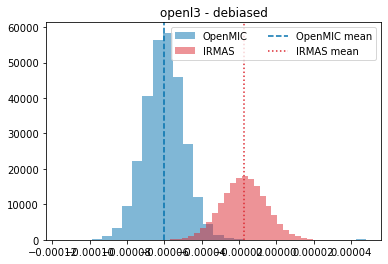

In [113]:
plt.title(f'{FEATURES} - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=data[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=data[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(data[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(data[1]))
plt.legend(ncol=2)

In [114]:
U2 = umap.UMAP(verbose=True, random_state=2022)

In [115]:
#U2.fit(Xdeb)
U2.fit(Xdeb[np.random.choice(len(X), size=50000)])

UMAP(random_state=2022, verbose=True)
Wed Apr 13 13:55:06 2022 Construct fuzzy simplicial set
Wed Apr 13 13:55:07 2022 Finding Nearest Neighbors
Wed Apr 13 13:55:07 2022 Building RP forest with 16 trees
Wed Apr 13 13:55:09 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations
Wed Apr 13 13:55:17 2022 Finished Nearest Neighbor Search
Wed Apr 13 13:55:18 2022 Construct embedding


Epochs completed: 100%| ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 200/200 [00:30]


Wed Apr 13 13:55:54 2022 Finished embedding


UMAP(random_state=2022, verbose=True)

In [116]:
#emb2 = U2.embedding_
emb2 = U2.transform(Xdeb)

Wed Apr 13 13:56:15 2022 Worst tree score: 0.54098000
Wed Apr 13 13:56:15 2022 Mean tree score: 0.54985250
Wed Apr 13 13:56:15 2022 Best tree score: 0.55530000
Wed Apr 13 13:56:16 2022 Forward diversification reduced edges from 750000 to 309494
Wed Apr 13 13:56:16 2022 Reverse diversification reduced edges from 309494 to 309494
Wed Apr 13 13:56:16 2022 Degree pruning reduced edges from 362636 to 361413
Wed Apr 13 13:56:16 2022 Resorting data and graph based on tree order
Wed Apr 13 13:56:17 2022 Building and compiling search function


Epochs completed: 100%| ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ 30/30 [00:36]


/home/bmcfee/miniconda/envs/ismir2022embedding/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/bmcfee/miniconda/envs/ismir2022embedding/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


[Text(0.5, 1.0, 'openl3 - debiased')]

<Figure size 576x576 with 1 Axes>

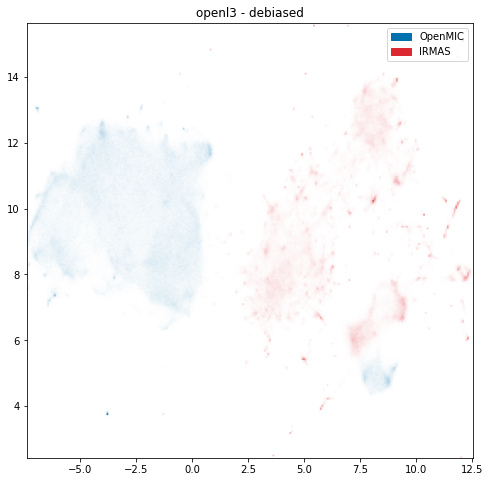

In [117]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

handles = []

for c in [0, 1]:
    ax.scatter_density(emb2[Y == c][:, 0], emb2[Y==c][:, 1], color=colors[c], dpi=50)
    handles.append(mpatches.Patch(color=colors[c], label=data[c]))
    
ax.legend(handles=handles)
ax.set(title=f'{FEATURES} - debiased')